# Análise 1 - Tendências e Preferências relacionadas a buscas 

## 1 - Importação das bibliotecas:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datetime import date
import re
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2 - Definição dos parâmetros para a leitura do arquivo:

In [2]:
# Nome do arquivo a ser lido
csv_file = 'out.csv'
# Quantidade de linhas do arquivo a ser lida por vez
chunk_size = 300000
# Nome das colunas do arquivo para adicionar ao DataFrame
cols = ['id','idusers','idsearch','companhia_aerea','tipo_de_voo','aeroporto_ida','aeroporto_volta','data_ida','data_volta','dias_entre_viagem','qtd_adultos','qtd_criancas','qtd_bebes','pais_ida','pais_volta','voo_internacional','direcao','classe','data_busca','data_inicio_buscador','data_fim_buscador','data_recebimento_busca','diff_segundos_inicio_fim_busca','diff_segundos_fim_busca_recebimento','qtd_voos','qtd_voos_recebidos','qtd_melhores_precos_cias','qtd_melhores_precos_mm','mais_barato_ida_mm','mais_barato_volta_mm','nome_aeroporto_ida','codinome_aeroporto_ida','combinacao_aeroporto_ida','grupo_aeroporto_ida','nome_aeroporto_volta','codinome_aeroporto_volta','combinacao_aeroporto_volta','grupo_aeroporto_volta']
# Dataset temporário para ler o arquivo em 42 partes de aproximadamente 300000 linhas 
chunk_dataset = pd.read_csv(csv_file,chunksize=chunk_size, sep=';', header=None, engine='python', names=cols, encoding='cp1252')

## 3 - Separar somente as informações necessárias a análise e realizar tratamentos nos dados:

### Declarações de funções

In [3]:
def selecionarDadosAnalise(chunk):
    indice_busca = ['companhia_aerea','tipo_de_voo','aeroporto_ida','aeroporto_volta','data_ida','data_volta','dias_entre_viagem','qtd_adultos','qtd_criancas','qtd_bebes','pais_ida','pais_volta','voo_internacional','direcao','classe','data_busca']
    return chunk.loc[:,indice_busca]

In [4]:
def preencherDadosFaltantes(chunk):
    #Preencher dados numéricos nulos com 0:
    chunk['dias_entre_viagem'].fillna(value=0, inplace=True)
    chunk['qtd_adultos'].fillna(value=0, inplace=True)
    chunk['qtd_criancas'].fillna(value=0, inplace=True)
    chunk['qtd_bebes'].fillna(value=0, inplace=True)
    chunk['companhia_aerea'].fillna(value='', inplace=True)
    chunk['tipo_de_voo'].fillna(value='', inplace=True)
    chunk['aeroporto_ida'].fillna(value='', inplace=True)
    chunk['aeroporto_volta'].fillna(value='', inplace=True)
    chunk['data_ida'].fillna(value='', inplace=True)
    chunk['data_volta'].fillna(value='', inplace=True)
    chunk['pais_ida'].fillna(value='', inplace=True)
    chunk['pais_volta'].fillna(value='', inplace=True)
    chunk['voo_internacional'].fillna(value='', inplace=True)
    chunk['direcao'].fillna(value='', inplace=True)
    chunk['classe'].fillna(value='', inplace=True)
    chunk['data_busca'].fillna(value='', inplace=True)

In [5]:
def validarRegistros(chunk):
    # Validar se tem companhia aérea na busca e o tipo de voo
    chunk = chunk.loc[(chunk['companhia_aerea'].notnull()) & (chunk['tipo_de_voo'].notnull())]
    # Validar se tem os dados da ida completos
    chunk = chunk.loc[(chunk['data_ida'].isnull()) | (chunk['data_ida'].notnull()) & (chunk['aeroporto_ida'].notnull())]
    # Validar se tem os dados da volta completos
    chunk = chunk.loc[(chunk['data_volta'].isnull()) | (chunk['data_volta'].notnull()) & (chunk['aeroporto_volta'].notnull())]
    # Validar se é um voo internacional e suas características
    chunk = chunk.loc[(chunk['voo_internacional'] == "NÃO") | (chunk['voo_internacional'] == "SIM") & (chunk['pais_ida'].notnull()) & (chunk['pais_volta'].notnull())]                  
    return(chunk)

In [6]:
# Validador de datas - Corrigir datas corrompidas no dataset
def validarData(data):
    p1 = '%Y-%m-%d %H:%M:%S.%f\n\d{5}'
    p2 = '%Y-%m-%d %H:%M:%S'
    if re.match(p1,str(data)):
        data = data.strftime('%Y-%m-%d')
        return data
    elif re.match(p2,str(data)):
        data = data.strftime('%Y-%m-%d')
        return data
    else:
        return None

In [7]:
# Conferir e corrigir datas
def converterDatas(chunk):
    if validarData(chunk['data_ida']):
        chunk['data_ida'] = validarData(chunk['data_ida'])
    if validarData(chunk['data_volta']):
        chunk['data_volta'] = validarData(chunk['data_volta'])
    if validarData(chunk['data_busca']):
         chunk['data_busca'] = validarData(chunk['data_busca'])

In [8]:
# Converter dados de float para inteiros
def converterIntervaloDias(chunk):
    chunk['dias_entre_viagem'] = chunk.dias_entre_viagem.astype(int)
    chunk['qtd_adultos'] = chunk.qtd_adultos.astype(int)
    chunk['qtd_criancas'] = chunk.qtd_criancas.astype(int)
    chunk['qtd_bebes'] = chunk.qtd_bebes.astype(int)

In [9]:
soma = 0
amostra = pd.DataFrame()
# Para cada parte do dataset
for chunk in chunk_dataset:  
    # Realizar a filtragem dos dados para trabalhar só com o suporte a busca
    chunk_filter = selecionarDadosAnalise(chunk)
    
    # Validar registros
    validarRegistros(chunk_filter)
    
    #Converter datas
    converterDatas(chunk_filter)
    
    #Preencher dados faltantes
    preencherDadosFaltantes(chunk_filter)
    
    #Converter intervalo dias
    converterIntervaloDias(chunk_filter)
    
    #Obter amostras de cada chunk para verificar a correlação dos dados e fazer o estudo das informações
    amostra = amostra.append(chunk_filter.sample(frac=0.05, random_state=77))

In [10]:
# Total de linhas da amostra
len(amostra)

621723

In [11]:
# Pré - Visualização dos dados de amostra
amostra.head()

,companhia_aerea,tipo_de_voo,aeroporto_ida,aeroporto_volta,data_ida,data_volta,dias_entre_viagem,qtd_adultos,qtd_criancas,qtd_bebes,pais_ida,pais_volta,voo_internacional,direcao,classe,data_busca
69438,TAM,Ida/Volta,CWB,BPS,2017-01-15 00:00:00.0,2017-01-22 00:00:00.0,7,1,0,0,BR,BR,NÃO,BR-BR,Econômica,2017-01-01 20:52:44.0
134626,AVIANCA,Ida/Volta,XAP,FOR,2017-02-24 00:00:00.0,2017-02-28 00:00:00.0,4,2,0,0,BR,BR,NÃO,BR-BR,Econômica,2017-01-02 11:10:33.0
207901,TAM,Ida,ATM,REC,2017-01-06 00:00:00.0,,0,1,0,0,BR,BR,NÃO,BR-BR,Econômica,2017-01-02 16:42:38.0
223123,TAM,Ida/Volta,FOR,SCL,2017-08-09 00:00:00.0,2017-08-17 00:00:00.0,8,7,0,0,BR,CL,SIM,BR-INTL,Econômica,2017-01-02 17:56:56.0
15664,TAM,Ida,MAB,RIO,2017-01-23 00:00:00.0,,0,1,0,0,BR,BR,NÃO,BR-BR,Econômica,2017-01-01 11:13:52.0


Há dados não numéricos bem interessantes a análise, portanto irei codificá-los em numéricos através do pré processamento LabelEncoder para correlacioná-los:

In [14]:
# Criação do objeto de pré processamento LabelEncoder 
enc = LabelEncoder()

Agora iremos usar o objeto **enc** para transformar os dados em inteiros que os representem:

In [15]:
# Processo de codificação dos dados com o LabelEncoder
comp_aereas_int = enc.fit_transform(amostra['companhia_aerea'])
tipo_voo_int = enc.fit_transform(amostra['tipo_de_voo'])
voo_internacional_int = enc.fit_transform(amostra['voo_internacional'])
direcao_int = enc.fit_transform(amostra['direcao'])
classe_int = enc.fit_transform(amostra['classe'])
data_busca_int = enc.fit_transform(amostra['data_busca'])
data_ida_int = enc.fit_transform(amostra['data_ida'])
data_volta_int = enc.fit_transform(amostra['data_volta'])
aeroporto_ida_int = enc.fit_transform(amostra['aeroporto_ida'])
aeroporto_volta_int = enc.fit_transform(amostra['aeroporto_volta'])

Acrescentando os novos dados codificados ao dataset:

In [16]:
amostra['comp_aereas_int'] = comp_aereas_int
amostra['tipo_voo_int'] = tipo_voo_int
amostra['voo_internacional_int'] = voo_internacional_int
amostra['direcao_int'] = direcao_int
amostra['classe_int'] = classe_int
amostra['data_busca_int'] = data_busca_int
amostra['data_ida_int'] = data_ida_int
amostra['data_volta_int'] = data_volta_int
amostra['aeroporto_ida_int'] = aeroporto_ida_int
amostra['aeroporto_volta_int'] = aeroporto_volta_int

In [17]:
#Visualizar a correlação dos dados
amostra.corr()

,dias_entre_viagem,qtd_adultos,qtd_criancas,qtd_bebes,comp_aereas_int,tipo_voo_int,voo_internacional_int,direcao_int,classe_int,data_busca_int,data_ida_int,data_volta_int,aeroporto_ida_int,aeroporto_volta_int
dias_entre_viagem,1.000000,0.019032,0.018977,0.006978,0.025836,0.348642,0.198837,0.157981,0.022700,0.018752,0.128895,0.420890,-0.009655,-0.008403
qtd_adultos,0.019032,1.000000,0.249106,0.126692,-0.005785,0.040916,0.022231,0.013422,0.023484,-0.020390,0.105074,0.097026,-0.017889,0.006503
qtd_criancas,0.018977,0.249106,1.000000,0.121045,-0.001734,0.004162,-0.001293,-0.002849,0.006980,-0.015623,0.065565,0.053832,-0.019113,-0.004416
qtd_bebes,0.006978,0.126692,0.121045,1.000000,-0.000581,-0.009552,-0.011205,-0.010053,-0.007282,-0.006690,0.011356,0.008047,-0.012592,-0.003483
comp_aereas_int,0.025836,-0.005785,-0.001734,-0.000581,1.000000,0.008069,0.111182,0.105395,0.023584,-0.011993,0.028756,0.023457,-0.004503,-0.018247
tipo_voo_int,0.348642,0.040916,0.004162,-0.009552,0.008069,1.000000,0.061054,0.018806,0.016140,0.072309,0.228253,0.722567,-0.038169,0.025679
voo_internacional_int,0.198837,0.022231,-0.001293,-0.011205,0.111182,0.061054,1.000000,0.923494,0.142094,0.001584,0.226818,0.189315,0.007528,-0.044491
direcao_int,0.157981,0.013422,-0.002849,-0.010053,0.105395,0.018806,0.923494,1.000000,0.125555,0.005349,0.192049,0.128739,-0.004317,-0.036296
classe_int,0.022700,0.023484,0.006980,-0.007282,0.023584,0.016140,0.142094,0.125555,1.000000,0.014528,0.041409,0.034665,-0.004781,-0.002107
data_busca_int,0.018752,-0.020390,-0.015623,-0.006690,-0.011993,0.072309,0.001584,0.005349,0.014528,1.000000,0.373046,0.206187,-0.009988,-0.000976


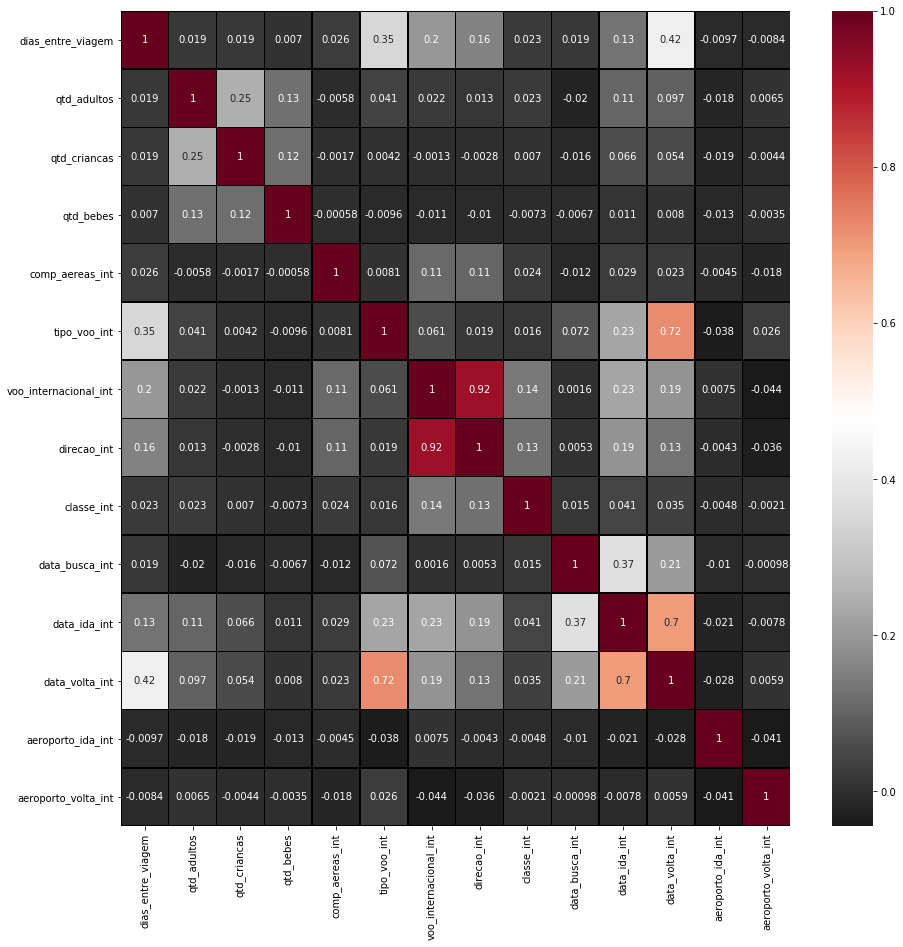

In [18]:
#Visualização melhor das correlações através de um heatmap:
%matplotlib inline
plt.figure(figsize=(15,15))
sns.heatmap(amostra.corr(), annot=True, linewidths=0.5, linecolor='black', cmap='RdGy_r')
plt.xticks(rotation=90)
plt.savefig("heatmap_corr.png", dpi=150) 
plt.show()

Através desse heatmap podemos observar algumas correlações:<br>

* O tempo de duração da viagem também se correlaciona de forma positiva com o tipo de voo (pessoas com viagens mais longas tem a tendência de já adquirir as passagens de ida e de volta juntas)
* Adultos tem maior correlação positiva em relação a crianças em comparação a bebês, ou seja, maior tendência de viajar com crianças.
* Companhias Aéreas e voos internacionais possuem uma correlação interessante, pode indicar a preferência de clientes por uma determinada companhia para esse tipo de voo.

## Quantificação dos dados para validar tendências e correlações

In [75]:
# Validar aquisição de passagens ida/volta em viagens mais longas
print(amostra.loc[(amostra['dias_entre_viagem'] > 10) & (amostra['tipo_de_voo'] == 'Ida/Volta')].count())
print(amostra.loc[(amostra['dias_entre_viagem'] > 10) & (amostra['tipo_de_voo'] == 'Ida')].count())

companhia_aerea      55581
tipo_de_voo          55581
aeroporto_ida        55581
aeroporto_volta      55581
data_ida             55581
data_volta           55581
dias_entre_viagem    55581
qtd_adultos          55581
qtd_criancas         55581
qtd_bebes            55581
pais_ida             55581
pais_volta           55581
voo_internacional    55581
direcao              55581
classe               55581
data_busca           55581
dtype: int64
companhia_aerea      0
tipo_de_voo          0
aeroporto_ida        0
aeroporto_volta      0
data_ida             0
data_volta           0
dias_entre_viagem    0
qtd_adultos          0
qtd_criancas         0
qtd_bebes            0
pais_ida             0
pais_volta           0
voo_internacional    0
direcao              0
classe               0
data_busca           0
dtype: int64


In [15]:
# Quantificar voos por companhia aérea para voos internacionais

print(amostra.loc[(amostra['voo_internacional'] == 'SIM') & (amostra['companhia_aerea'] == 'AZUL')].count())
print(amostra.loc[(amostra['voo_internacional'] == 'SIM') & (amostra['companhia_aerea'] == 'AVIANCA')].count())
print(amostra.loc[(amostra['voo_internacional'] == 'SIM') & (amostra['companhia_aerea'] == 'GOL')].count())
print(amostra.loc[(amostra['voo_internacional'] == 'SIM') & (amostra['companhia_aerea'] == 'TAM')].count())

companhia_aerea      18260
tipo_de_voo          18260
aeroporto_ida        18260
aeroporto_volta      18260
data_ida             18260
data_volta           18260
dias_entre_viagem    18260
qtd_adultos          18260
qtd_criancas         18260
qtd_bebes            18260
pais_ida             18260
pais_volta           18260
voo_internacional    18260
direcao              18260
classe               18260
data_busca           18260
dtype: int64
companhia_aerea      342
tipo_de_voo          342
aeroporto_ida        342
aeroporto_volta      342
data_ida             342
data_volta           342
dias_entre_viagem    342
qtd_adultos          342
qtd_criancas         342
qtd_bebes            342
pais_ida             342
pais_volta           342
voo_internacional    342
direcao              342
classe               342
data_busca           342
dtype: int64
companhia_aerea      23759
tipo_de_voo          23759
aeroporto_ida        23759
aeroporto_volta      23759
data_ida             23759
data_vo

In [17]:
# Quantificar voos por companhia aérea para voos nacionais
print(amostra.loc[(amostra['voo_internacional'] == 'NÃO') & (amostra['companhia_aerea'] == 'AVIANCA')].count())
print(amostra.loc[(amostra['voo_internacional'] == 'NÃO') & (amostra['companhia_aerea'] == 'AZUL')].count())
print(amostra.loc[(amostra['voo_internacional'] == 'NÃO') & (amostra['companhia_aerea'] == 'GOL')].count())
print(amostra.loc[(amostra['voo_internacional'] == 'NÃO') & (amostra['companhia_aerea'] == 'TAM')].count())

companhia_aerea      166200
tipo_de_voo          166200
aeroporto_ida        166200
aeroporto_volta      166200
data_ida             166200
data_volta           166200
dias_entre_viagem    166200
qtd_adultos          166200
qtd_criancas         166200
qtd_bebes            166200
pais_ida             166200
pais_volta           166200
voo_internacional    166200
direcao              166200
classe               166200
data_busca           166200
dtype: int64
companhia_aerea      77602
tipo_de_voo          77602
aeroporto_ida        77602
aeroporto_volta      77602
data_ida             77602
data_volta           77602
dias_entre_viagem    77602
qtd_adultos          77602
qtd_criancas         77602
qtd_bebes            77602
pais_ida             77602
pais_volta           77602
voo_internacional    77602
direcao              77602
classe               77602
data_busca           77602
dtype: int64
companhia_aerea      144924
tipo_de_voo          144924
aeroporto_ida        144924
aeroporto_

In [70]:
# Validar preferência de companhia aérea para voos internacionais
print(amostra.loc[(amostra['qtd_criancas'] > 0)].count())
print(amostra.loc[(amostra['qtd_bebes'] > 0)].count())

companhia_aerea      34452
tipo_de_voo          34452
aeroporto_ida        34452
aeroporto_volta      34452
data_ida             34452
data_volta           34452
dias_entre_viagem    34452
qtd_adultos          34452
qtd_criancas         34452
qtd_bebes            34452
pais_ida             34452
pais_volta           34452
voo_internacional    34452
direcao              34452
classe               34452
data_busca           34452
dtype: int64
companhia_aerea      9670
tipo_de_voo          9670
aeroporto_ida        9670
aeroporto_volta      9670
data_ida             9670
data_volta           9670
dias_entre_viagem    9670
qtd_adultos          9670
qtd_criancas         9670
qtd_bebes            9670
pais_ida             9670
pais_volta           9670
voo_internacional    9670
direcao              9670
classe               9670
data_busca           9670
dtype: int64


## Dispersão dos dados

### Funções para a criação dos gráficos

In [35]:
# Função para plotagem dos gráficos de dispersão com regressão linear
def plotarDispersoesRegressao(n_linhas,n_elem,axis,features,colors, titles,labels):
    fig, (axis) = plt.subplots(n_linhas, n_elem, figsize=(20, 5))   
    qtd_itens = len(axis)
    i = 0
    while i < qtd_itens:
        axis[i] = sns.regplot(x = amostra[features[i][0]], y = amostra[features[i][1]], data=amostra, color=colors[i], line_kws={'color':'red'}, ax=axis[i])
        axis[i].set_title(titles[i])
        i+=1        
    plt.subplots_adjust(wspace=1)
    plt.savefig("dispersao3.png", dpi=150) 
    plt.show()

In [23]:
# Função para plotagem dos gráficos de dispersão
def plotarDispersoes(axis,features,colors, titles):
    fig, (axis) = plt.subplots(ncols=len(axis), figsize=(20, 5))   
    qtd_itens = len(axis)
    i = 0
    while i < qtd_itens:
        axis[i].hist(amostra[features[i]], 10, density=True, histtype='stepfilled', facecolor=colors[i], alpha=0.75)
        axis[i].set_title(titles[i])
        i+=1
    fig.tight_layout()
    plt.savefig("dispersao2.png", dpi=150) 
    plt.show()


## Exibição dos gráficos e análises dos dados

### Pesquisas por quantidade de adultos, crianças e bebês

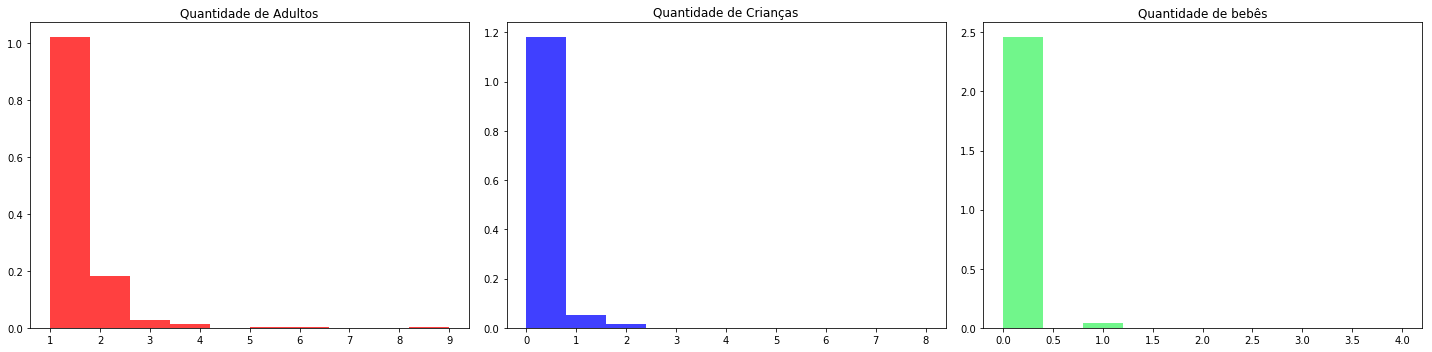

In [22]:
# Configuração do primeiro panel de gráficos de dispersão
axis = ['ax0','ax1','ax2']
features = ['qtd_adultos', 'qtd_criancas', 'qtd_bebes']
colors = ['red', 'blue','#42f465']
titles = ['Quantidade de Adultos', 'Quantidade de Crianças', 'Quantidade de bebês']
plotarDispersoes(axis,features,colors,titles)

Pode-se observar que há uma grande tendência de que as pessoas pesquisem mais por viagens para ir sozinhas, sem parceiros ou filhos. Quando pretendem viajam acompanhadas, geralmente buscam por viajar com mais uma pessoa, poucas vezes viajando com mais 3 ou 4 adultos. Quanto a crianças, geralmente planejam viajar com um filho somente, raramente levando dois. Quando se trata de bebês, geralmente não pesquisam ou em poucos casos, buscam levar somente um bebê.

### Duração da viagem em relação a quantidade de adultos, crianças e bebês

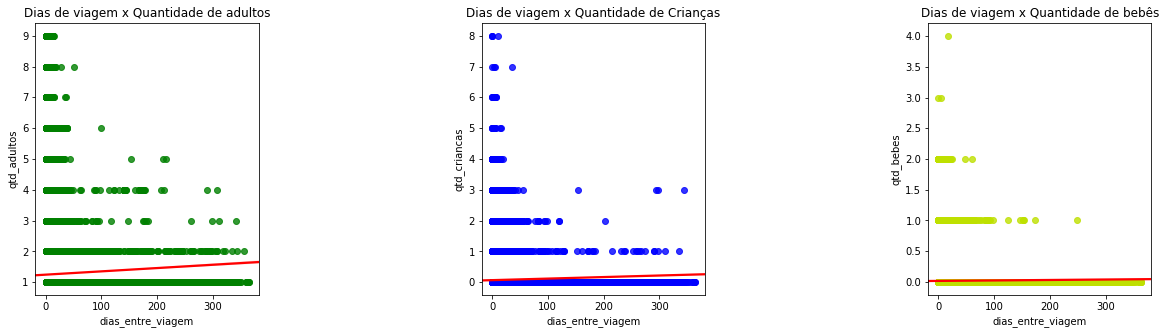

In [36]:
# Configuração do primeiro panel de gráficos de dispersão
axis = ['ax0','ax1','ax2','ax3']
features = [['dias_entre_viagem','qtd_adultos'],['dias_entre_viagem','qtd_criancas'],['dias_entre_viagem','qtd_bebes']]
labels = [['Dias de viagem','Quantidade de adultos'],['Dias de viagem', 'Quantidade de Crianças'],['Dias de viagem','Quantidade de bebês']]
colors = ['g', 'b','#bee000']
titles = ['Dias de viagem x Quantidade de adultos', 'Dias de viagem x Quantidade de Crianças', 'Dias de viagem x Quantidade de bebês']
plotarDispersoesRegressao(1,3,axis,features,colors,titles,labels)

Quanto a duração da viagem, pode-se verificar que quanto mais pessoas adultas há na busca em questão, verifica-se que a duração da viagem é menor, o que pode ser justificado no preço a ser pago por passagens,hospedagens, dentre outros. As mesmas tendências de redução dos dias de viagem em relação ao aumento de pessoas também podem ser observadas, porém com menor intensidade, nas quantidades de crianças e bebês.

### Relações entre adultos e crianças, adultos e bebês e crianças e bebês

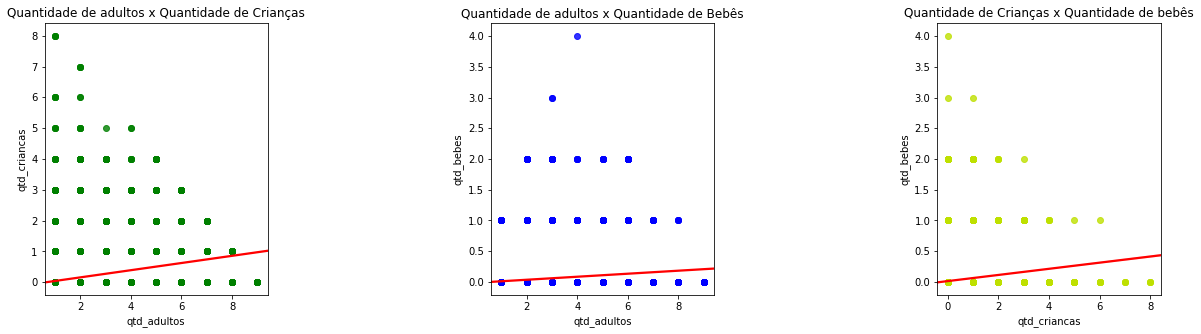

In [76]:
# Configuração do primeiro panel de gráficos de dispersão
axis = ['ax0','ax1','ax2']
features = [['qtd_adultos','qtd_criancas'],['qtd_adultos','qtd_bebes'],['qtd_criancas','qtd_bebes']]
labels = [['Quantidade de adultos','Quantidade de Crianças'],['Quantidade de adultos', 'Quantidade de Bebês'],['Quantidade de Crianças','Quantidade de bebês']]
colors = ['g', 'b','#bee000']
titles = ['Quantidade de adultos x Quantidade de Crianças', 'Quantidade de adultos x Quantidade de Bebês', 'Quantidade de Crianças x Quantidade de bebês']
plotarDispersoesRegressao(1,3,axis,features,colors,titles,labels)

A quantidade de adultos e a quantidade de crianças é uma correlação positiva mais aparente em relação a quantidade de adultos e bebês, confirmando através da regressão que há uma maior tendência de pesquisar passagens para crianças em relação a passagens para bebês. Quanto a relação de busca entre bebês e crianças, há uma leve correlação positiva, então se uma família possui uma criança e um bebê, a tendência é que queiram levá-lo também.